# Logistic Regression & Decision Tree Models
### for healthcare frauds detection

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy import mean, where
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import time
from collections import Counter
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, log_loss, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from sklearn import metrics
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import random
SEED = 1234

In [2]:
# import the cleaned dataset 

%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB
partB = pd.read_csv("processed_partB.csv")

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset


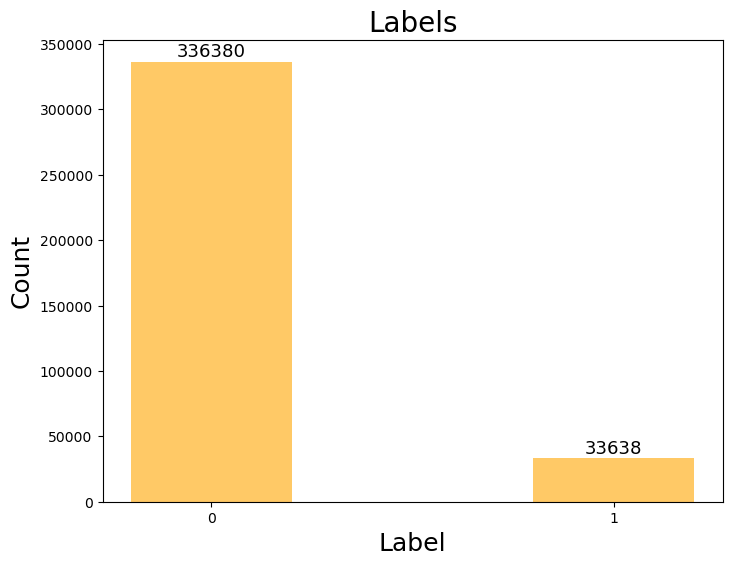

In [3]:
# preprocessed and Under-sampled data (processed_partB.csv) 
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [4]:
# One-Hot Encoding 

# Convert the Fraud variable to object datatype
partB["Fraud"] = partB["Fraud"].astype(object)

# Encoding
encoded_partB = pd.get_dummies(partB, drop_first = True)

# Rename some of the changed variable names
encoded_partB.rename(columns = {"Fraud_1":"Fraud", "Place_Of_Srvc_O":"Place_Of_Srvc"}, inplace = True)

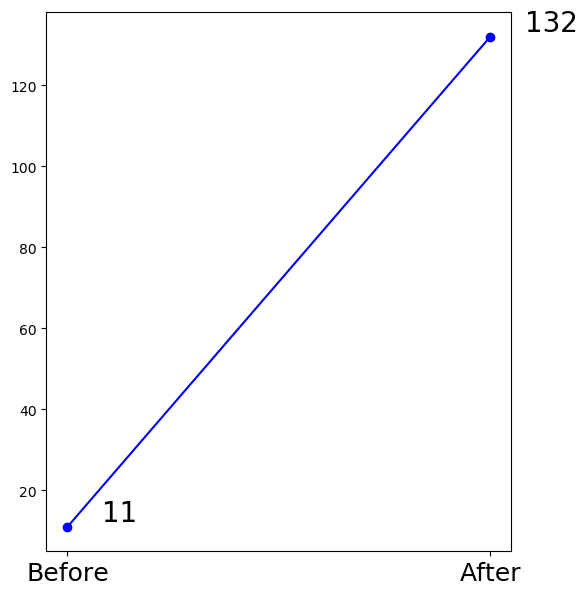

In [5]:
# Feature size of the encoded dataset 

fig, ax = plt.subplots(figsize=(6,7))

xs = ["Before", "After"]
ys = [len(partB.columns), len(encoded_partB.columns)]
ax.plot(xs, ys, "bo-")

for x,y in zip(xs, ys):
    label = "{:d}".format(y)
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(25,4), 
                 ha='left',
                fontsize = 20) 
    
ax.set_xticklabels(xs, fontsize=18)

plt.show()

### Data Partitioning 

In [6]:
# Assign X and y features

X_var = list(encoded_partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [35]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(encoded_partB[X_var], 
                                                    encoded_partB[y_var], 
                                                    test_size=0.2, 
                                                    stratify=encoded_partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

### Multicollinearity

In [8]:
cont_features = partB.columns.tolist()
for var in ["NPI", "Type", 'Place_Of_Srvc', "Fraud"]:
    cont_features.remove(var)

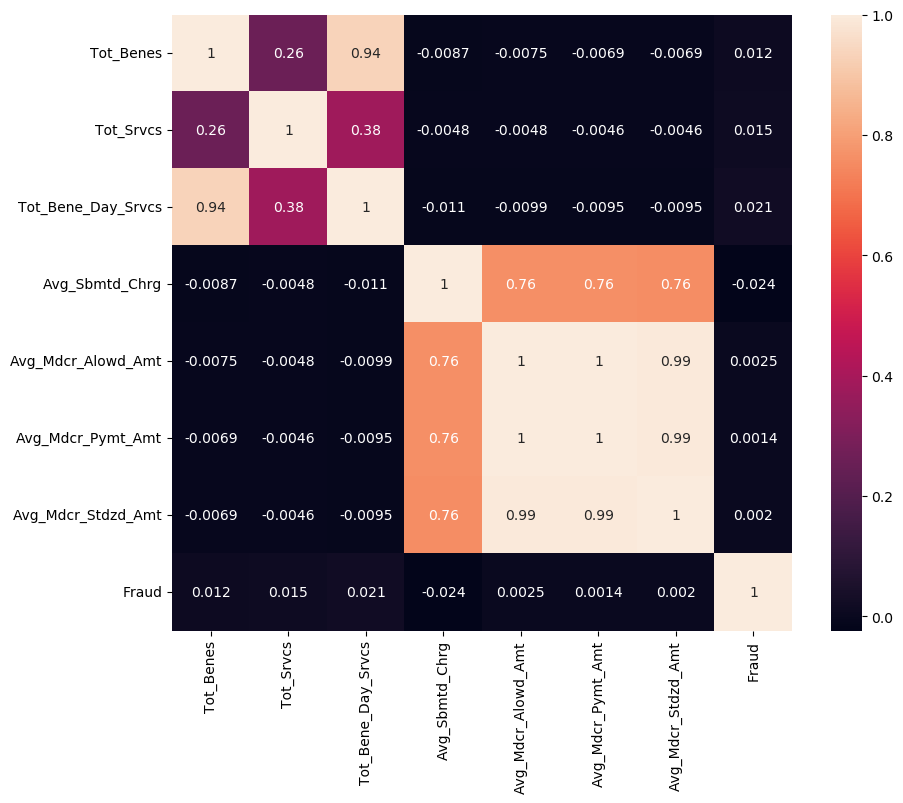

In [10]:
# Check Multicollinearity 
plt.figure(figsize = (10,8))

corr = tr_df[cont_features + [y_var]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

plt.show()

### Data distribution & Outliers

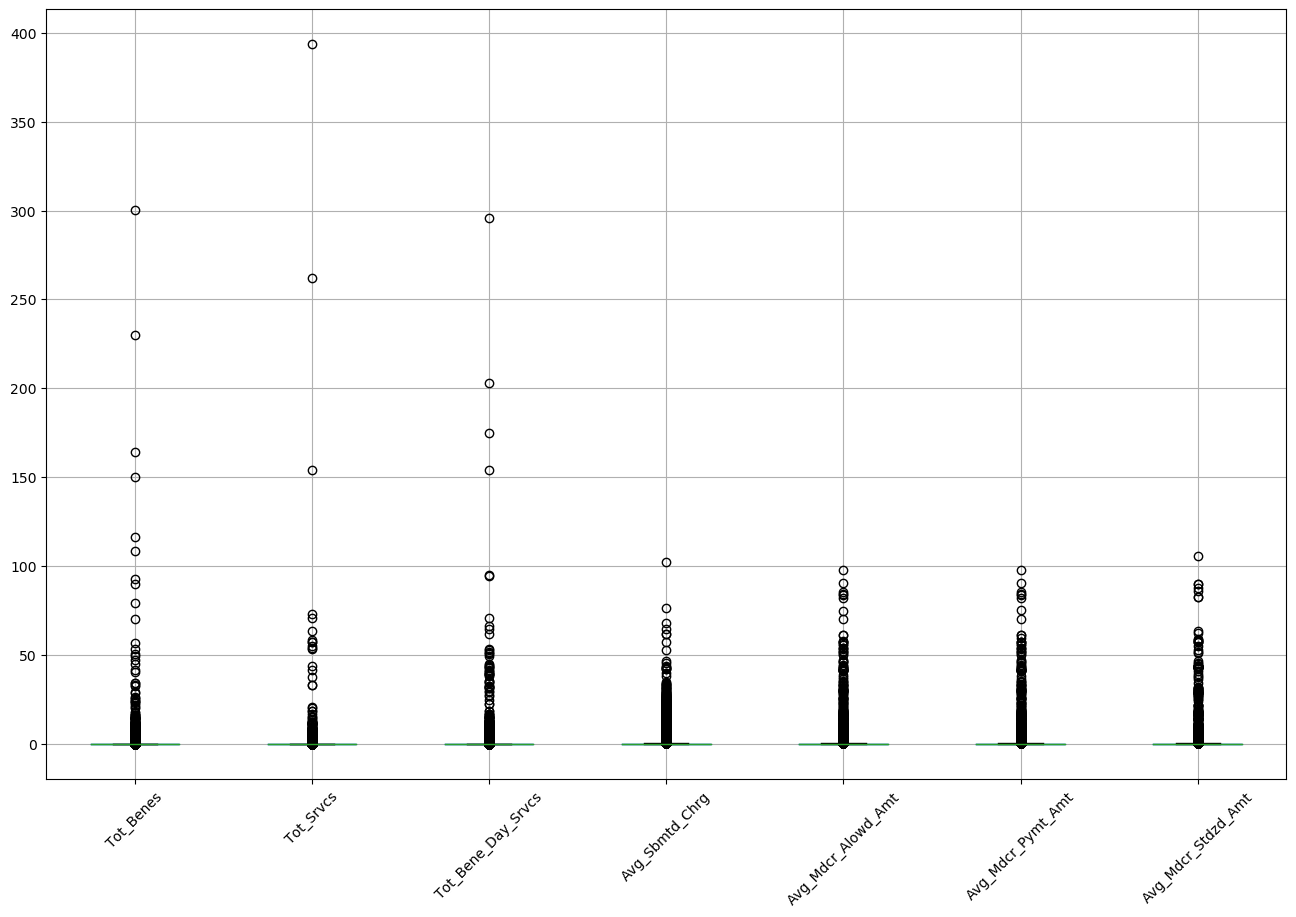

In [11]:
# in order to draw the box plots of all the features in the same y-axis, scale the variables 
scaled_tr = pd.DataFrame(scale(tr_df[cont_features]), columns = cont_features)

# box plots for the continous variables 
plt.figure(figsize=(16, 10))

scaled_tr.boxplot()
plt.xticks(rotation=45)
plt.show()

### Delete Outliers

In [12]:
# Outlier = |z-score| > 3
def detect_outlier(var_list):
    
    threshold=3
    outliers_idx = {}
    outliers_data = {}
    
    
    for col in var_list:
        
        mean1 = np.mean(tr_df[col])
        std1 =np.std(tr_df[col])

        z_score = np.abs((tr_df[col] - mean1)/std1)
        outliers_idx[col] =  z_score.index[z_score > threshold].tolist()
        outliers_data[col] =  z_score[z_score > threshold].tolist()
       
    return outliers_idx, outliers_data

In [13]:
outliers_idx_dict, outliers_data_dict = detect_outlier(cont_features)

In [14]:
# Find the unique indeces of the detected outliers

outliers_list = outliers_idx_dict.get("Tot_Benes")
for i in np.arange(1, len(cont_features)):
    outliers_list.extend(outliers_idx_dict.get(cont_features[i]))
    
outlier_uniq_idx = np.unique(outliers_list).tolist()


# delete the ourlier rows from the train set

orgl_len = len(tr_df)

tr_df = tr_df.drop(index = outlier_uniq_idx, axis = 0)

deleted_rows = orgl_len - len(tr_df)
print("the number of deleted rows: %d" % deleted_rows)

the number of deleted rows: 4711


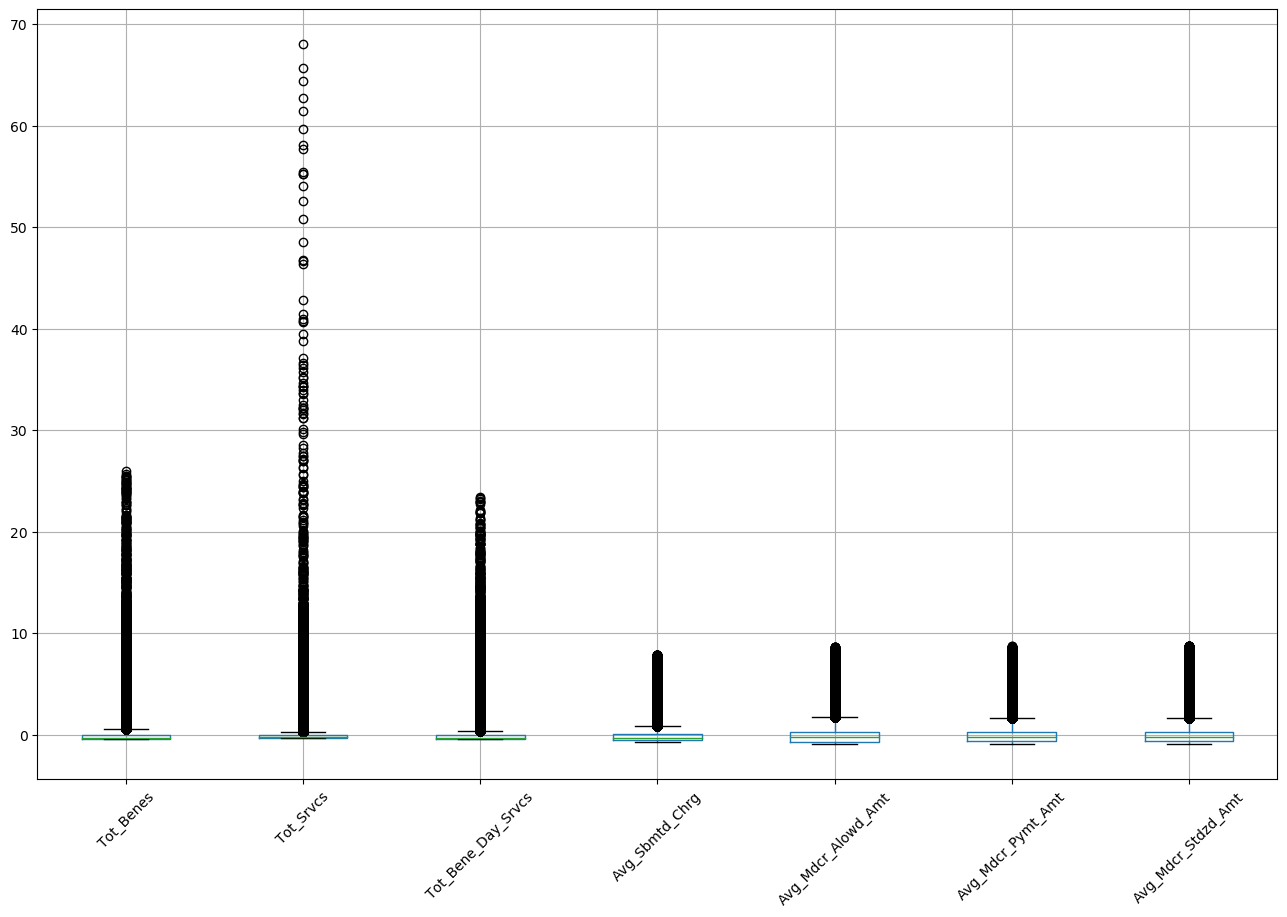

In [15]:
# Box plots for Outlier-free train set

# To draw the box plots of all the features in the same y-axis, scale the variables
scaled_tr_outlierFree = pd.DataFrame(scale(tr_df[cont_features]), columns = cont_features)

# box plots for the continous variables 
plt.figure(figsize=(16, 10))

scaled_tr_outlierFree.boxplot()
plt.xticks(rotation=45)
plt.show()

### Log_transformation

In [16]:
trans_tr_df = tr_df.copy(deep = True)

In [17]:
trans_tr_df[cont_features] = np.log10(trans_tr_df[cont_features])

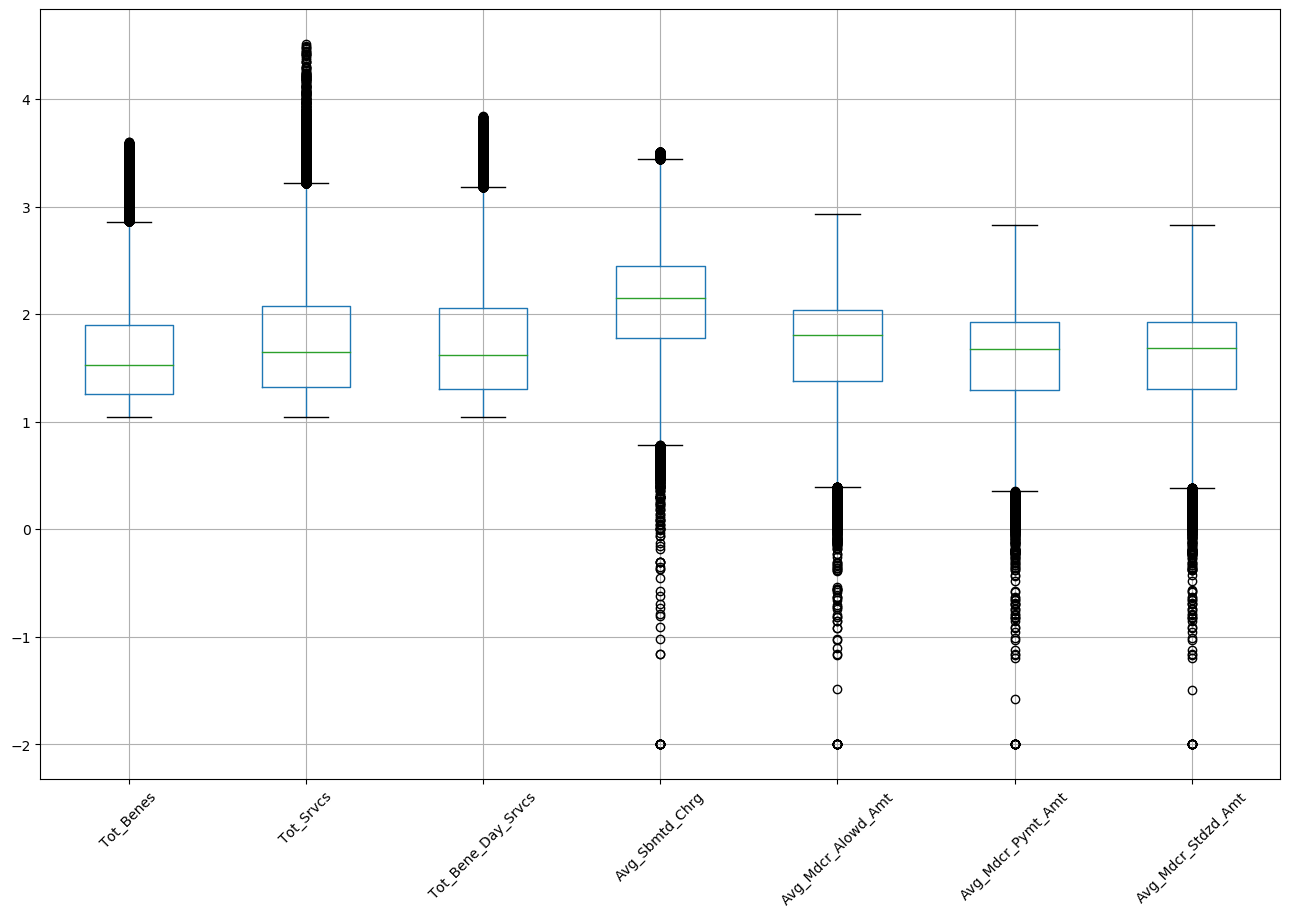

In [18]:
plt.figure(figsize=(16, 10))

trans_tr_df[cont_features].boxplot()
plt.xticks(rotation=45)
plt.show()

### Skewness & Kurtosis

In [19]:
# infinite values
np.isinf(trans_tr_df[cont_features]).sum(axis=0)

Tot_Benes             0
Tot_Srvcs             0
Tot_Bene_Day_Srvcs    0
Avg_Sbmtd_Chrg        0
Avg_Mdcr_Alowd_Amt    0
Avg_Mdcr_Pymt_Amt     3
Avg_Mdcr_Stdzd_Amt    4
dtype: int64

In [20]:
# remove the detected rows with infinite values across all the columns 
inf_idx = trans_tr_df[cont_features].index[np.isinf(trans_tr_df[cont_features]).any(1)]
trans_tr_df = trans_tr_df.drop(inf_idx)

In [21]:
trans_tr_df[cont_features].agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
Tot_Benes,0.808055,0.151615
Tot_Srvcs,0.847701,0.277662
Tot_Bene_Day_Srvcs,0.800654,0.064510
Avg_Sbmtd_Chrg,-0.074545,0.157272
Avg_Mdcr_Alowd_Amt,-0.575438,0.140940
Avg_Mdcr_Pymt_Amt,-0.461109,0.057264
Avg_Mdcr_Stdzd_Amt,-0.477922,0.083162


### Over-Sampling the imbalnaced data through SMOTE

In [22]:
# transform the dataset
oversample = over_sampling.SMOTE(random_state = SEED)
tr_X, tr_y = oversample.fit_resample(trans_tr_df[X_var], trans_tr_df[y_var])

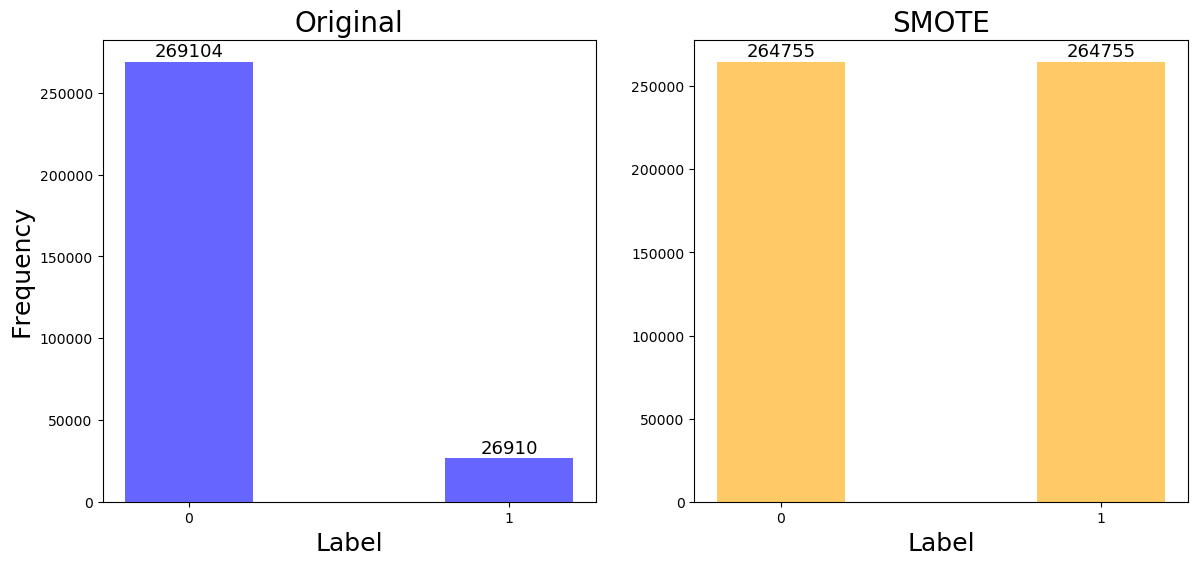

In [23]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(y_train.value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(tr_y.value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

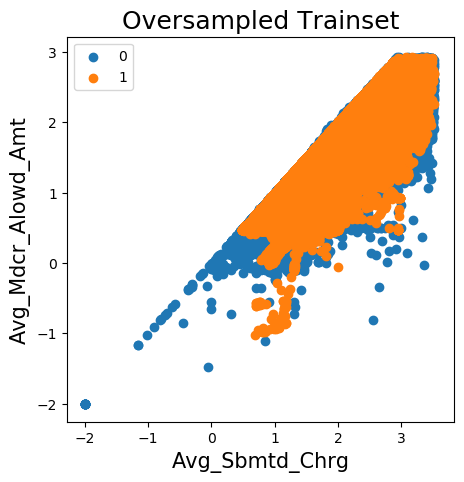

In [24]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(5, 5))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### Logistic Regression

In [25]:
trainDF = pd.concat([tr_X, pd.DataFrame(tr_y, columns = ["Fraud"])], axis=1)

In [26]:
train_logit = sm.Logit(trainDF[y_var],sm.add_constant(trainDF[cont_features])).fit()
train_logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 5


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Fraud   No. Observations:               529510
Model:                          Logit   Df Residuals:                   529502
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Dec 2021   Pseudo R-squ.:                     inf
Time:                        21:33:54   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1308      0.017     -7.645      0.000      -0.164      -0.097
Tot_Benes             -0.7999      0.016    -49.327      0.000      -0.832      -0.768
Tot_Srvcs              0.3602      0.028     12.817      0.000       0.305       0.415
Tot_Bene_Day_Srvcs     0.6747      0.032     21.249      0.000       0.613       0.737
Avg_Sbmtd_Chrg        -0.9784      0.011    -86.318      0.000      -1.001      -0.956
Avg_Mdcr_Alowd_Amt     0.3005      0.046      6.581      0.000       0.211       0.390
Avg_Mdcr_Pymt_Amt     -0.7595      0.070    -10.910      0.000      -0.896      -0.623
Avg_Mdcr_Stdzd_Amt     1.4605      0.058     25.241      0.000       1.347       1.574
======================================================================================
"""

### Prediction on test set

In [32]:
testX = te_df[cont_features]

In [36]:
logreg = LogisticRegression()
logreg.fit(trainDF[cont_features], trainDF[y_var])

y_pred = logreg.predict(testX)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(testX, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


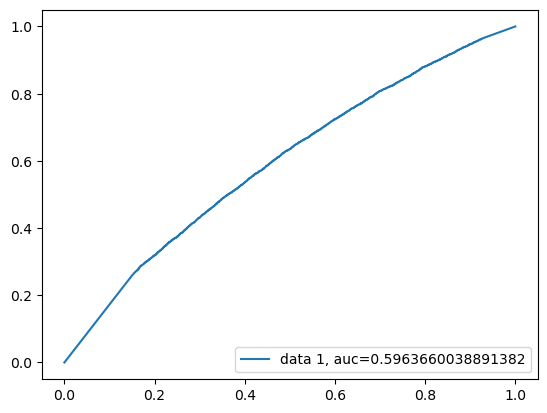

In [37]:
y_pred_proba = logreg.predict_proba(testX)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [43]:
print("MSE:", mean_squared_error(y_test,y_pred))
print("Logloss:",log_loss(y_test,y_pred))
print("f1-score:",f1_score(y_test,y_pred))

MSE: 0.29180855088914115
Logloss: 10.078898962467193
f1-score: 0.1937651670711219


### Decision Tree

In [45]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", random_state=SEED)

In [48]:
# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for train/test dataset
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

In [49]:
classes = ['Non-Fraud','Fraud']

In [50]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Train score 0.9999797306884134
Test score 0.8820334035998054
Train Confusion matrix


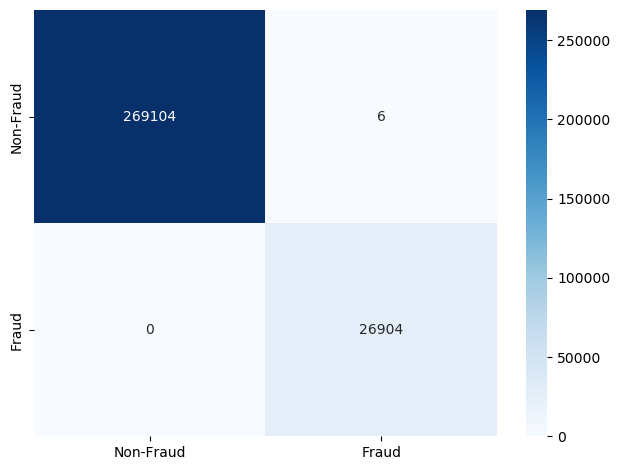

Test Confusion matrix


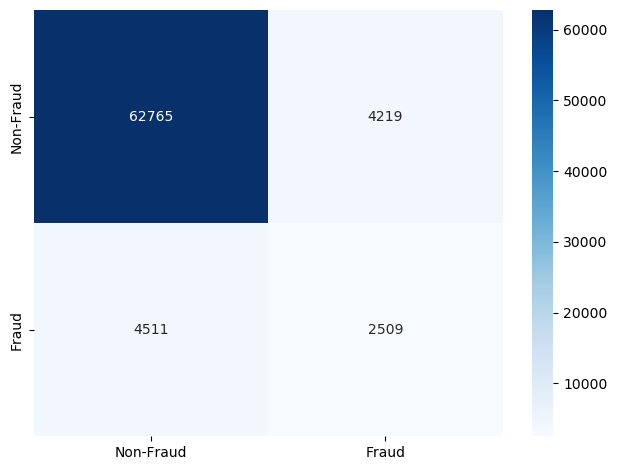

In [51]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

### Pre-Prunning

In [53]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [54]:
gcv.best_estimator_

DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=3)

Train score 0.9171660799827035
Test score 0.9118155775363493
Train Confusion matrix


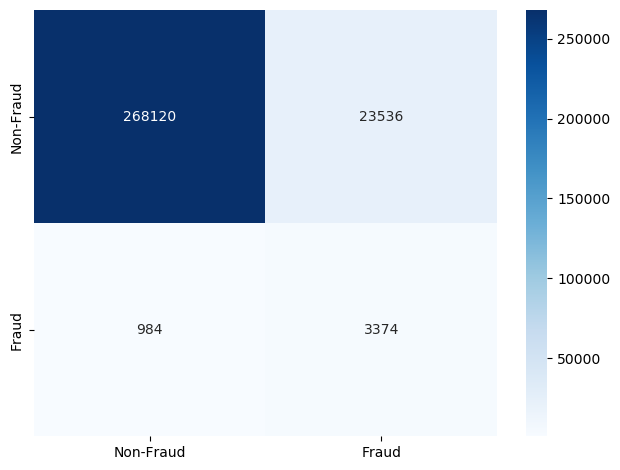

Test Confusion matrix


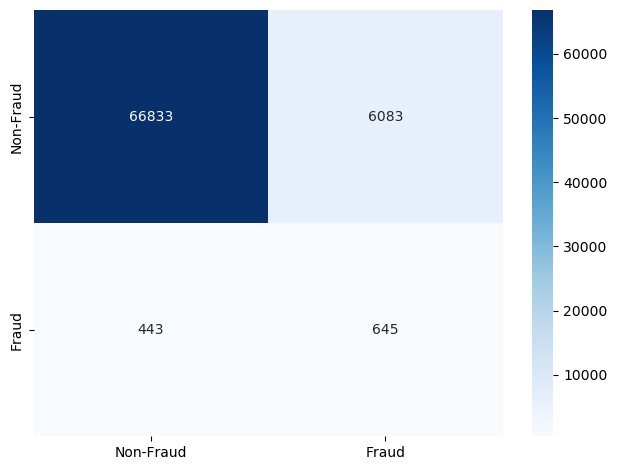

In [55]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

### Post-Prunning

In [56]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 1.12607287e-06 1.34089292e-06 ... 1.31743145e-03
 1.55464048e-03 2.97104306e-03]


In [57]:
ccp_alphas = [0.00000000e+00, 8.44554649e-07,1.12607287e-06, 2.00190732e-06, 3.00286098e-06, 4.00749461e-06, 
              4.50429146e-06, 5.06732790e-06, 6.08079348e-06, 7.10695004e-06, 1.00186986e-05, 2.65367804e-05,
              3.91107637e-05, 4.27735486e-05, 5.73948304e-05, 6.11006488e-05, 7.20649402e-05, 8.71908433e-05, 
              9.56183319e-05, 0.00016608, 0.00017035, 0.0001871, 0.00026861, 0.00042659, 0.00052418, 
              0.00062436, 0.00076177, 0.00089972, 0.00090666, 0.00092514, 0.00103783, 0.00125498]

In [59]:
# For each alpha we will append our model to a list

clf_tic = time.time()

clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

clf_toc = time.time() - clf_tic
print('clf training completed in %.2f s.' % (clf_toc))

clf training completed in 354.23 s.


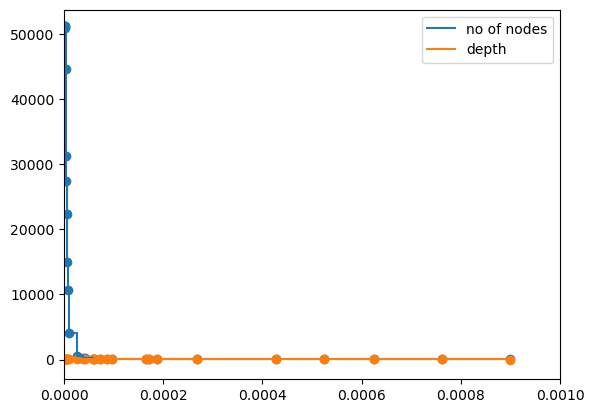

In [63]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.xlim([0, 0.001])
plt.legend()
plt.show()

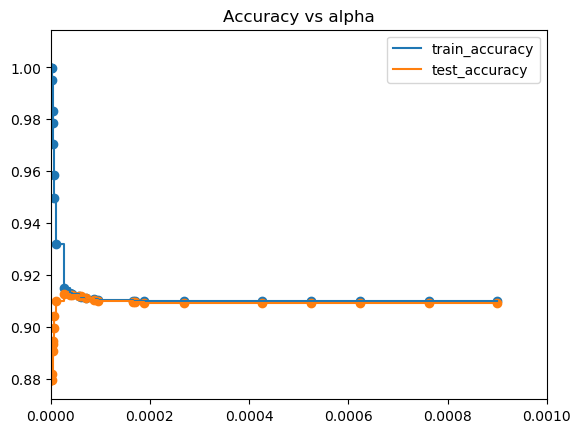

In [65]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.xlim([0, 0.001])
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

* alpha = 0.0002

Train score 0.9999797306884134
Test score 0.879493000378358
Train Confusion matrix


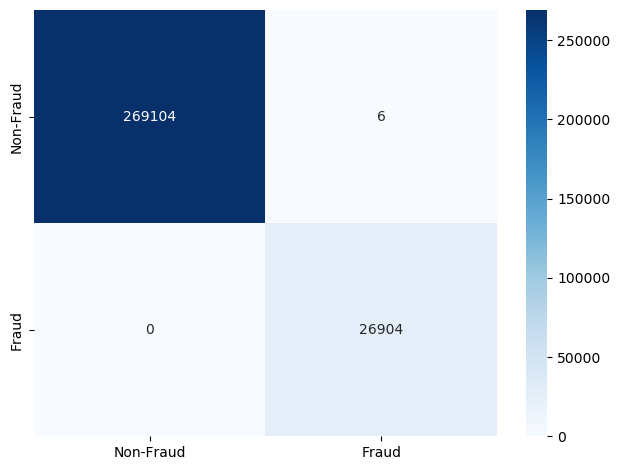

Test Confusion matrix


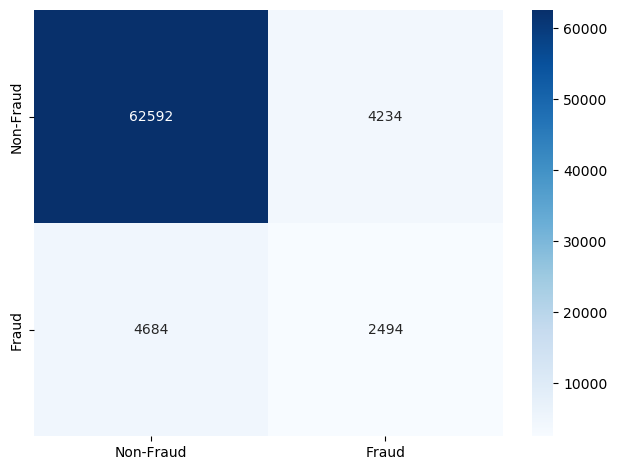

In [66]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=8.44554649e-07)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [67]:
print("MSE:", mean_squared_error(y_test,y_test_pred))
print("Logloss:",log_loss(y_test,y_test_pred))
print("f1-score:",f1_score(y_test,y_test_pred))

MSE: 0.12050699962164207
Logloss: 4.162214923574084
f1-score: 0.35869408888249676


In [70]:
tree.plot_tree(clf)

[Text(198.4, 323.4, 'X[129] <= 0.5\ngini = 0.165\nsamples = 296014\nvalue = [269104, 26910]'),
 Text(99.2, 230.99999999999997, 'gini = 0.081\nsamples = 113516\nvalue = [108744, 4772]'),
 Text(297.6, 230.99999999999997, 'X[62] <= 0.5\ngini = 0.213\nsamples = 182498\nvalue = [160360, 22138]'),
 Text(198.4, 138.6, 'X[44] <= 0.5\ngini = 0.209\nsamples = 181197\nvalue = [159762, 21435]'),
 Text(99.2, 46.19999999999999, 'gini = 0.204\nsamples = 179501\nvalue = [158839, 20662]'),
 Text(297.6, 46.19999999999999, 'gini = 0.496\nsamples = 1696\nvalue = [923, 773]'),
 Text(396.8, 138.6, 'gini = 0.497\nsamples = 1301\nvalue = [598, 703]')]

In [71]:
pip install pydotplus

     |████████████████████████████████| 278 kB 284 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=0b6ec026e6f214f7582aa6cfcb546b62eaf028b473a611cd5cc62d6439192ad4
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [72]:
F_var = x_test.columns

In [73]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = F_var,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

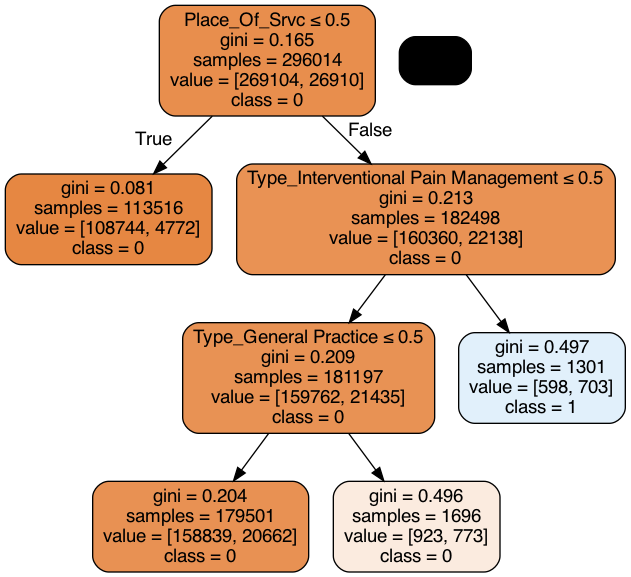

In [74]:
Image(graph.create_png())

In [77]:
fig = plt.figure(figsize=(125,120))
_ = tree.plot_tree(clf, 
                   feature_names=F_var,  
                   class_names=y_var,
                   filled=True)
plt.show()